# Linear Systems

Solving linear systems of the form
$$
A \mathbf{x} = \mathbf{b}
$$

where $A$ is symmetric positive definite is arguably one of the most fundamental computations in statistics, machine learning and scientific computation at large. Many problems can be reduced to the solution of one or many (large-scale) linear systems. Some examples include least-squares regression, kernel methods, second-order optimization, quadratic programming, Kalman filtering, linear differential equations and all Gaussian (process) inference. Here, we will solve such a system using a *probabilistic linear solver*.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

## Test Problems
We begin by creating a random linear system with a symmetric positive definite matrix. ProbNum lets you quickly generate test problems via its problem zoo.

In [2]:
import numpy as np
from probnum.problems.zoo.linalg import random_spd_matrix

# Random symmetric positive definite linear system
rng = np.random.default_rng(42)
n = 25

A = random_spd_matrix(
    rng=rng, dim=n, spectrum=10 * np.linspace(0.5, 1, n) ** 4
)
b = rng.normal(size=(n, 1))

print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))
print("Eigenvalues: {}".format(np.linalg.eigvalsh(A)))

Matrix condition: 16.00
Eigenvalues: [ 0.625       0.73585981  0.8608519   1.00112915  1.15788966  1.33237674
  1.52587891  1.73972989  1.97530864  2.23403931  2.51739125  2.82687905
  3.1640625   3.53054659  3.92798153  4.35806274  4.82253086  5.32317173
  5.86181641  6.44034115  7.06066744  7.72476196  8.43463662  9.19234853
 10.        ]


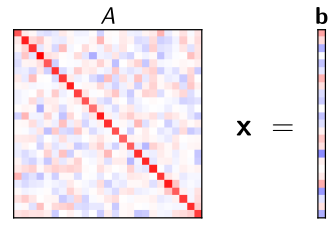

In [3]:
# Plot linear system
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(5, 3.5),
    sharey=True,
    squeeze=False,
    gridspec_kw={"width_ratios": [4, 0.25, 0.25, 0.25]},
)

vmax = np.max(np.abs(np.hstack([A, b])))
vmin = -vmax
axes[0, 0].imshow(A, cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("$A$", fontsize=24)
axes[0, 1].text(0.5, A.shape[0] / 2, "$\\bm{x}$", va="center", ha="center", fontsize=32)
axes[0, 1].axis("off")
axes[0, 2].text(0.5, A.shape[0] / 2, "$=$", va="center", ha="center", fontsize=32)
axes[0, 2].axis("off")
axes[0, 3].imshow(b, cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 3].set_title("$\\bm{b}$", fontsize=24)
for ax in axes[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

For example ``suitesparse_matrix`` lets you download matrices from the [SuiteSparse Matrix Collection](http://sparse.tamu.edu/), which is a repository of sparse benchmark matrices.

In [4]:
from probnum.problems.zoo.linalg import suitesparse_matrix

Asparse = suitesparse_matrix(name="662_bus", group="HB")
Asparse

662_bus:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

3,HB,662_bus,662,662,2474,float64,False,True,1.0,1.0,power network problem,


## Prior Information

We might have access to prior information about the inverse of $A$. Suppose we know something about the eigenvalue structure of $H=A^{-1}$. This is for example the case for Gram matrices generated by a specific kernel. In this case we assume that the average eigenvalue of the inverse is $\bar{\sigma}=\text{avg}(\sigma(H)) \approx 0.5$.

In [5]:
# Average eigenvalue of inverse
print(np.mean(1 / np.linalg.eigvalsh(A)))

0.48286034731003646


Prior information is encoded in random variables modelling $A$ and $H$. Here, we will use our prior information about the spectrum by providing a prior mean for the inverse of the form $H_0 = \operatorname{diag}(\bar{\sigma})$.

In [6]:
import probnum.randvars as randvars
from probnum.linops import Identity, Scaling, SymmetricKronecker
from probnum.linalg import problinsolve

# Prior distribution on A
W0H = Identity(n)
covA = SymmetricKronecker(W0H)
Ainv0 = randvars.Normal(mean=Scaling(0.5, shape=(n, n)), cov=covA)

## Probabilistic Linear Solvers

We now use a *probabilistic linear solver*, taking into account the prior information we just specified, to solve the linear system. The algorithm iteratively chooses *actions* $\mathbf{s}$ and makes linear *observations* $\mathbf{y}=A \mathbf{s}$ to update its belief over the solution, the matrix and its inverse.

In [7]:
# Probabilistic linear solver
x, Ahat, Ainv, info = problinsolve(A=A, b=b, Ainv0=Ainv0, maxiter=10)
print(info)

{'iter': 10, 'maxiter': 10, 'resid_l2norm': 0.018257718674779048, 'trace_sol_cov': 23.854200758409913, 'conv_crit': 'maxiter', 'rel_cond': None}


{'iter': 10, 'maxiter': 10, 'resid_l2norm': 0.018257718674779048, 'trace_sol_cov': 23.854200758409913, 'conv_crit': 'maxiter', 'rel_cond': None}
/home/jwenger/Documents/research/probabilistic_numerics/code/probnum/src/probnum/linalg/solvers/matrixbased.py:548: UserWarning: Iteration terminated. Solver reached the maximum number of iterations.
  warnings.warn(


## Numerical Uncertainty

The solver returns random variables $\mathsf{x}$, $\mathsf{A}$ and $\mathsf{H}$, which quantify numerical uncertainty in the solution, the linear operator itself and the estimate of the inverse. For illustration we stopped the solver early after $k=10 < n$ iterations. We plot means and samples from the resulting distributions of $\mathsf{A}$ and $\mathsf{H}$.

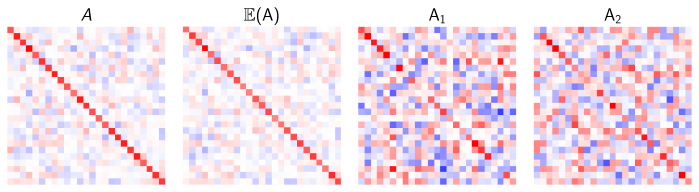

In [9]:
# Draw samples
rng = np.random.default_rng(seed=42)
Ahat_samples = Ahat.sample(rng=rng, size=3)
Ainv_samples = Ainv.sample(rng=rng, size=3)

# Plot
rvdict = {
    "$A$": A,
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathsf{A}_1$": Ahat_samples[0],
    "$\mathsf{A}_2$": Ahat_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

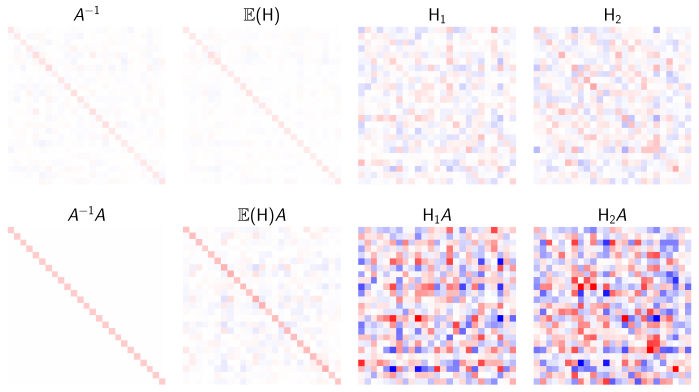

In [10]:
# Plot
rvdict = {
    "$A^{-1}": np.linalg.inv(A),
    "$\mathbb{E}(\mathsf{H})": Ainv.mean.todense(),
    "$\mathsf{H}_1": Ainv_samples[0],
    "$\mathsf{H}_2": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=2, ncols=len(rvdict), figsize=(10, 6), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[0, i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[0, i].set_axis_off()
    axes[0, i].title.set_text(title + "$")

    axes[1, i].imshow(rv @ A, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[1, i].set_axis_off()
    axes[1, i].title.set_text(title + "A$")
plt.tight_layout()

Even though the solver has only explored a subspace of dimension $k \ll n$, the mean estimates for the matrix and its inverse are already close. This is in part due to the informative prior that we used. We can see that the uncertainty of the solver about these quantities is still relatively high by looking at the samples from $\mathsf{A}$ and $\mathsf{H}$ .